# Milk Classification Project

Import all packages, prepare our dataframe using kaggle dataset from https://www.kaggle.com/datasets/cpluzshrijayan/milkquality

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import chi2, SelectKBest,SelectPercentile, f_classif
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

df = pd.read_csv(r'C:\Users\ryvo1\Downloads\milknew.csv')
df.head()

,pH,Temprature,Taste,Odor,Fat,Turbidity,Colour,Grade
0,6.6,35,1,0,1,0,254,high
1,6.6,36,0,1,0,1,253,high
2,8.5,70,1,1,1,1,246,low
3,9.5,34,1,1,0,1,255,low
4,6.6,37,0,0,0,0,255,medium


Now, check for null values:

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1059 entries, 0 to 1058
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   pH          1059 non-null   float64
 1   Temprature  1059 non-null   int64  
 2   Taste       1059 non-null   int64  
 3   Odor        1059 non-null   int64  
 4   Fat         1059 non-null   int64  
 5   Turbidity   1059 non-null   int64  
 6   Colour      1059 non-null   int64  
 7   Grade       1059 non-null   object 
dtypes: float64(1), int64(6), object(1)
memory usage: 66.3+ KB


In [3]:
df.shape

(1059, 8)

Therefore, df does not contain any null values.

### Train/Test Split

We want to make a prediction model for the variable 'Grade', so we isolate it as our y variable:

In [4]:
x = df.drop(columns='Grade')
y = df['Grade']
y.value_counts()

low       429
medium    374
high      256
Name: Grade, dtype: int64

Since we have an imbalance, we'll use SMOTE to randomly increase minority classes (medium and high, in this case), so we don't experience oversampling:

In [5]:
bettersample = SMOTE(random_state=0)
x, y = bettersample.fit_resample(x,y)
y.value_counts()

high      429
low       429
medium    429
Name: Grade, dtype: int64

Now, we just normalize our values, and perform our train/test split:

In [6]:
scaler = MinMaxScaler()
x = scaler.fit_transform(x)
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.20,random_state=0)

### Feature Selection

Models often perform better when only using a few key variables, which we will see if we can find.

Let's look for variables which are significant in predicting milk grade:

In [7]:
df.corr()

,pH,Temprature,Taste,Odor,Fat,Turbidity,Colour
pH,1.000000,0.244684,-0.064053,-0.081331,-0.093429,0.048384,-0.164565
Temprature,0.244684,1.000000,-0.109792,-0.048870,0.024073,0.185106,-0.008511
Taste,-0.064053,-0.109792,1.000000,0.017582,0.324149,0.055755,-0.082654
Odor,-0.081331,-0.048870,0.017582,1.000000,0.314505,0.457935,-0.039361
Fat,-0.093429,0.024073,0.324149,0.314505,1.000000,0.329264,0.114151
Turbidity,0.048384,0.185106,0.055755,0.457935,0.329264,1.000000,0.136436
Colour,-0.164565,-0.008511,-0.082654,-0.039361,0.114151,0.136436,1.000000


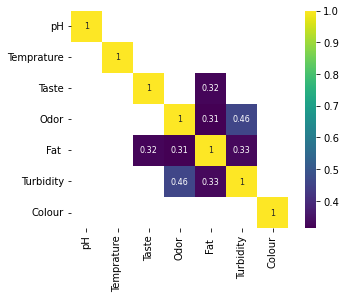

In [8]:
corr = df.corr()
sns.heatmap(corr[(corr >= 0.3) | (corr <= -0.3)], 
            cmap='viridis', annot=True, annot_kws={"size": 8}, square=True);

Now we have an idea of which variables might be useful, but let's perform multiple tests and cross-validation:

#### Test 1: Chi-Squared

https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.chi2.html#sklearn.feature_selection.chi2

"Recall that the chi-square test measures dependence between stochastic variables, so using this function 'weeds out' the features that are the most likely to be independent of class and therefore irrelevant for classification."

In [9]:
from sklearn.feature_selection import chi2, SelectKBest
chi_best_col = SelectKBest(chi2,k='all')
kbest = chi_best_col.fit_transform(x,y)
pd.DataFrame(list(zip(df.drop(columns='Grade').columns,chi_best_col.scores_)),columns=['features','scores']).sort_values(by='scores',ascending=False)

,features,scores
5,Turbidity,176.612245
3,Odor,143.136134
4,Fat,114.145695
1,Temprature,53.486398
2,Taste,22.388350
6,Colour,11.012380
0,pH,0.102586


So this test supports the removal of 'Colour', 'Taste', 'pH' from our model.

#### Test 2: Anova

In statistics, an ANOVA is used to determine whether there is a statistically significant difference between the means of three or more independent groups.

In [10]:
from sklearn.feature_selection import f_classif, SelectKBest
f_best_col = SelectKBest(f_classif,k='all')
kbest1 = f_best_col.fit_transform(x,y)
pd.DataFrame(list(zip(df.drop(columns='Grade'),f_best_col.scores_)),columns=['features','scores']).sort_values(by='scores',ascending=False)

,features,scores
4,Fat,274.612533
5,Turbidity,239.518365
1,Temprature,218.876159
3,Odor,167.424755
6,Colour,56.358174
2,Taste,26.440420
0,pH,0.751890


So this test supports the removal of 'Colour', 'Taste', 'pH' from our model.

#### Test 3: Variance Threshold

To increse the score of the model we need a dataset that has high variance, so it will be good if we can select the features in the dataset which has variance more than a fixed threshold.

In [11]:
# Turns 'Grade' column into numerical representations, since this function works with numbers.
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
df['Grade'] = encoder.fit_transform(df['Grade'])

In [12]:
from sklearn.feature_selection import VarianceThreshold
v = VarianceThreshold(threshold=1)
v.fit_transform(df)
v.get_support()

array([ True,  True, False, False, False, False,  True, False])

In [13]:
df.columns

Index(['pH', 'Temprature', 'Taste', 'Odor', 'Fat ', 'Turbidity', 'Colour',
       'Grade'],
      dtype='object')

So this test supports the removal of 'pH', 'Temprature', 'Colour' from our model.

##### Therefore, through cross-validation of these tests, we will try making a model with parameters 'Temprature', 'Odor', 'Fat ', 'Turbidity', 'Taste'.

In [14]:
x1 = df[['Temprature', 'Odor', 'Fat ', 'Turbidity', 'Taste']]
y1 = df['Grade']
x1_train, x1_test, y1_train, y1_test = train_test_split(x1,y1,test_size=0.20,random_state=0)

### Model Selection

Let's find which model provides the highest accuracy prediction, using: 1. our set of "optimized" variables, and 2. our set of all variables.

#### Model 1: Decision Tree Classifier

In [15]:
# Runs DecisionTreeClassifier on our old split:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier()
dtc.fit(x_train,y_train)
y_pred = dtc.predict(x_test)

# Tests model's performance on cv=5 number of folds (to ensure it's working in general, not just on one section)
from sklearn.model_selection import cross_val_score
cross_validation_scores = cross_val_score(dtc,x,y,cv=5)
print(cross_validation_scores)
print("Average Score (Old set):", cross_validation_scores.mean())

[0.98449612 1.         1.         1.         0.9922179 ]
Average Score (Old set): 0.9953428045727385


In [16]:
# Runs DecisionTreeClassifier on our new train/test split:
dtc = DecisionTreeClassifier()
dtc.fit(x1_train,y1_train)
y1_pred = dtc.predict(x1_test)
cross_validation_scores = cross_val_score(dtc,x1,y1,cv=5)
print(cross_validation_scores)
print("Average Score (New set):", cross_validation_scores.mean())

[0.9009434  0.91037736 0.90566038 0.89622642 0.88625592]
Average Score (New set): 0.8998926942680855


#### Model 2: SVM Classifier

In [17]:
from sklearn.svm import SVC
svm_model_linear = SVC(kernel = 'linear', C = 1).fit(x_train, y_train)
y_pred = svm_model_linear.predict(x_test)
  
cross_validation_scores = cross_val_score(svm_model_linear,x,y,cv=5)
print(cross_validation_scores)
print("Average Score (Old set):", cross_validation_scores.mean())

[0.82170543 0.77131783 0.84824903 0.77821012 0.80155642]
Average Score (Old set): 0.8042077640032577


In [18]:
svm_model_linear = SVC(kernel = 'linear', C = 1).fit(x1_train, y1_train)
y1_pred = svm_model_linear.predict(x1_test)
  
cross_validation_scores = cross_val_score(svm_model_linear,x1,y1,cv=5)
print(cross_validation_scores)
print("Average Score (New set):", cross_validation_scores.mean())

[0.74528302 0.70754717 0.75       0.69811321 0.71090047]
Average Score (New set): 0.7223687740320128


#### Model 3: K-Nearest-Neighbors Classifier

In [19]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 7).fit(x_train, y_train)

cross_validation_scores = cross_val_score(knn,x,y,cv=5)
print(cross_validation_scores)
print("Average Score (Old set):", cross_validation_scores.mean())

[0.99612403 1.         0.98832685 0.99610895 0.9844358 ]
Average Score (Old set): 0.9929991252676983


In [20]:
knn = KNeighborsClassifier(n_neighbors = 7).fit(x1_train, y1_train)

cross_validation_scores = cross_val_score(knn,x1,y1,cv=5)
print(cross_validation_scores)
print("Average Score (New set):", cross_validation_scores.mean())

[0.91037736 0.91037736 0.90566038 0.9009434  0.86255924]
Average Score (New set): 0.8979835464544397


#### Model 4: Naive Bayes Classifier

(Assumes independence between the variables)

In [21]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB().fit(x_train, y_train)
gnb_predictions = gnb.predict(x_test)
  
cross_validation_scores = cross_val_score(gnb,x,y,cv=5)
print(cross_validation_scores)
print("Average Score (Old set):", cross_validation_scores.mean())

[0.8372093  0.91472868 0.90272374 0.92996109 0.87159533]
Average Score (Old set): 0.8912436280276296


In [22]:
gnb = GaussianNB().fit(x1_train, y1_train)
gnb_predictions = gnb.predict(x1_test)
  
cross_validation_scores = cross_val_score(gnb,x1,y1,cv=5)
print(cross_validation_scores)
print("Average Score (New set):", cross_validation_scores.mean())

[0.58962264 0.63207547 0.74056604 0.60377358 0.67772512]
Average Score (New set): 0.6487525708664938


#### Model 5: Logistic Regression

In [36]:
from sklearn.linear_model import LogisticRegression
lgr = LogisticRegression()
lgr.fit(x_train, y_train)
y_pred = lgr.predict(x_test)

cvs = cross_val_score(lgr,x,y,cv=5)
print(cvs)
print(cvs.mean())

[0.86821705 0.84108527 0.87937743 0.83657588 0.85992218]
0.8570355623925436


In [37]:
lgr = LogisticRegression()
lgr.fit(x1_train, y1_train)
y_pred = lgr.predict(x1_test)

cvs = cross_val_score(lgr,x1,y1,cv=5)
print(cvs)
print(cvs.mean())

C:\Users\ryvo1\anaconda3\envs\PIC16B\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ryvo1\anaconda3\envs\PIC16B\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logis

[0.73584906 0.73584906 0.75471698 0.71698113 0.73933649]
0.7365465438612179


C:\Users\ryvo1\anaconda3\envs\PIC16B\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### Model 6: Random Forest Classifier

In [23]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(x_train, y_train)
y_pred = rfc.predict(x_test)

cross_validation_scores = cross_val_score(rfc,x,y,cv=5)
print(cross_validation_scores)
print("Average Score (Old set):", cross_validation_scores.mean())

[0.99224806 1.         1.         1.         0.9922179 ]
Average Score (Old set): 0.9968931921696378


In [24]:
rfc = RandomForestClassifier()
rfc.fit(x1_train,y1_train)
y1_pred = rfc.predict(x1_test)

cross_validation_scores = cross_val_score(rfc,x1,y1,cv=5)
print(cross_validation_scores)
print("Average Score (New set):", cross_validation_scores.mean())

[0.89622642 0.91037736 0.90566038 0.89622642 0.8957346 ]
Average Score (New set): 0.9008450326388268


The best score comes from our Random Forest Classifier model. The original set of variables provided better scores for all six models.

### Hyperparameter Tuning

To ensure we are actually getting the best possible scores from our models, we will conduct hyperparameter tuning. 

This will show us if our set of all variables make for properly tuned hyperparameters.

In [126]:
param_dict = {
    "criterion":['gini','entropy'],
    "max_depth":range(1,10)
}
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(rfc,param_grid=param_dict,cv=5)
grid.fit(x_train,y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(max_depth=9),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 10)})

In [127]:
grid.best_params_

{'criterion': 'gini', 'max_depth': 6}

In [128]:
grid.best_score_

0.9990291262135923

Then, we have a highest accuracy of 99.9% via hyperparameter tuning. Applying these parameters to our current RandomForestClassifier gives:

In [137]:
rfc = RandomForestClassifier(criterion='gini',max_depth=6)
rfc.fit(x_train,y_train)
y_pred = rfc.predict(x_test)

cvsr = cross_val_score(rfc,x,y,cv=5)

print(classification_report(y_test,yr_pred))

print(cvsr)
print(cvsr.mean())

              precision    recall  f1-score   support

        high       0.99      0.99      0.99        93
         low       1.00      0.98      0.99        87
      medium       0.97      1.00      0.99        78

    accuracy                           0.99       258
   macro avg       0.99      0.99      0.99       258
weighted avg       0.99      0.99      0.99       258

[0.99224806 1.         1.         1.         0.9922179 ]
0.9968931921696378


As we can see, applying the best parameters provides a similarly strong precision score, and since our recall and f1-scores aren't too disparate, we have conclusively created a very strong model to predict milk grade using RandomForestClassifier.

# Summary and comments

In this project, I have:

- Imported a dataset of milk attributes and grade from https://www.kaggle.com/datasets/cpluzshrijayan/milkquality and converted it to a dataframe
- Prepared the data to perform a train/test split
- Cross-validated feature selection tests to find the strongest predicting features of milk grade
- Ran the most optimal possible sets of data through several appropriate ML models
- Conducted Hyperparameter tuning to ensure the selected features were indeed optimal
- Ended up with an accurate predictor of milk grade

This project was unique in that all of my models performed better when using all of the possible variables as hyperparameters, and the accuracy was higher than I'd usually expect. I'd chalk this up to the dataset, as similar projects of mine (such as this one: https://github.com/ryanvoda/Penguins-Project/blob/main/PenguinProjectWalkthrough.ipynb).